In [1]:
# Import the function
import sys
import os

from import_data import load_tiff_files

In [2]:
# Set the data folder path
data_folder = os.path.join(os.getcwd(), '../data')

# Load the tiff files
images = load_tiff_files(data_folder)

# Display the loaded images info
for name, img in images.items():
    print(f"Image: {name}, Shape: {img.shape}, Dtype: {img.dtype}")

Loaded Embryo_37_intrareg_fuse_t075.tif with shape (790, 2008, 845)
Loaded Embryo_37_intrareg_fuse_t076.tif with shape (790, 2008, 845)
Loaded Embryo_37_intrareg_fuse_t076.tif with shape (790, 2008, 845)
Loaded Embryo_37_intrareg_fuse_t077.tif with shape (790, 2008, 845)
Loaded Embryo_37_intrareg_fuse_t077.tif with shape (790, 2008, 845)
Loaded Embryo_37_intrareg_fuse_t078.tif with shape (790, 2008, 845)
Image: Embryo_37_intrareg_fuse_t075.tif, Shape: (790, 2008, 845), Dtype: uint16
Image: Embryo_37_intrareg_fuse_t076.tif, Shape: (790, 2008, 845), Dtype: uint16
Image: Embryo_37_intrareg_fuse_t077.tif, Shape: (790, 2008, 845), Dtype: uint16
Image: Embryo_37_intrareg_fuse_t078.tif, Shape: (790, 2008, 845), Dtype: uint16
Loaded Embryo_37_intrareg_fuse_t078.tif with shape (790, 2008, 845)
Image: Embryo_37_intrareg_fuse_t075.tif, Shape: (790, 2008, 845), Dtype: uint16
Image: Embryo_37_intrareg_fuse_t076.tif, Shape: (790, 2008, 845), Dtype: uint16
Image: Embryo_37_intrareg_fuse_t077.tif, Sha

In [4]:
import trackpy as tp

In [14]:
# Select one image for testing, e.g., the first one
image_name = list(images.keys())[0]
image = images[image_name]

# Perform 3D particle locating using trackpy
# Assuming nuclei diameter is around 10 pixels, adjust as needed
features = tp.locate(image, diameter=21, minmass=1_000_000)  # minmass to filter noise

# Display the detected features
print(f"Detected {len(features)} particles in {image_name}")
features.head()

Detected 3331 particles in Embryo_37_intrareg_fuse_t075.tif


,z,y,x,mass,size,ecc,signal,raw_mass,ep
572,87.403375,1469.726159,419.049051,1.192423e+06,6.859633,NaN,825.225701,10043611.0,0.004168
578,90.250798,1423.090233,405.460186,1.450710e+06,6.855402,NaN,1041.382761,11329269.0,0.003688
579,86.349438,1445.140147,421.556774,1.699103e+06,6.872046,NaN,1096.379244,11501451.0,0.003632
583,87.540415,1299.151247,403.880095,1.195678e+06,6.494980,NaN,1084.683789,10118864.0,0.004136
588,88.352338,1360.494310,397.341438,1.342130e+06,6.621528,NaN,1193.075591,10110439.0,0.004140


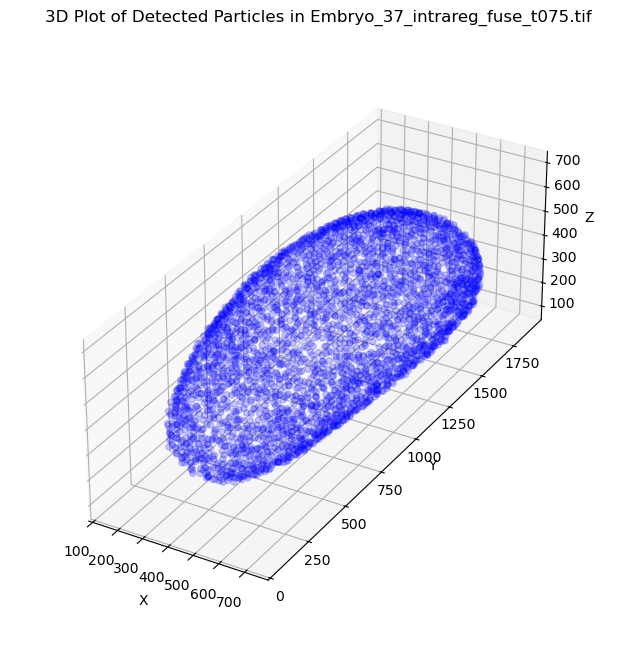

In [23]:
# Plot the detected features in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the features
ax.scatter(features['x'], features['y'], features['z'], c='blue', marker='o', alpha=0.2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Plot of Detected Particles in {image_name}')

#axis equal. plz copilot
# Calculate the range of each axis to set equal aspect ratio
x_range = features['x'].max() - features['x'].min()
y_range = features['y'].max() - features['y'].min()
z_range = features['z'].max() - features['z'].min()
max_range = max(x_range, y_range, z_range)
ax.set_box_aspect([x_range/max_range, y_range/max_range, z_range/max_range])


plt.show()

In [ ]:
# Load features for the first two images
import pandas as pd

image_names = list(images.keys())[:2]  # First two images
all_features = []

for i, name in enumerate(image_names):
    print(f"Processing image: {name}")
    img = images[name]
    feats = tp.locate(img, diameter=21, minmass=1_000_000)
    feats['frame'] = i  # Assign frame number
    all_features.append(feats)

    # save features to csv for inspection
    feats.to_csv(f'features_{name}_D21_minmass1000000.csv', index=False)


# Concatenate into one DataFrame
features_df = pd.concat(all_features, ignore_index=True)

# Link trajectories across frames
linked = tp.link_df(features_df, search_range=5, memory=0)  # Adjust search_range as needed

# Filter for trajectories present in both frames
trajectories = linked.groupby('particle').filter(lambda x: len(x) == 2)

print(f"Linked {len(trajectories['particle'].unique())} trajectories across 2 frames")
trajectories.head()

Frame 1: 10 trajectories present.
Linked 1 trajectories across 2 frames


,z,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
5,180.868228,193.832153,168.878464,1033.684201,3.628099,NaN,4.367945,66582.0,0.027102,0,5
17,183.514791,194.111242,168.922996,1016.347138,3.565832,NaN,4.572622,65924.0,0.043698,1,5


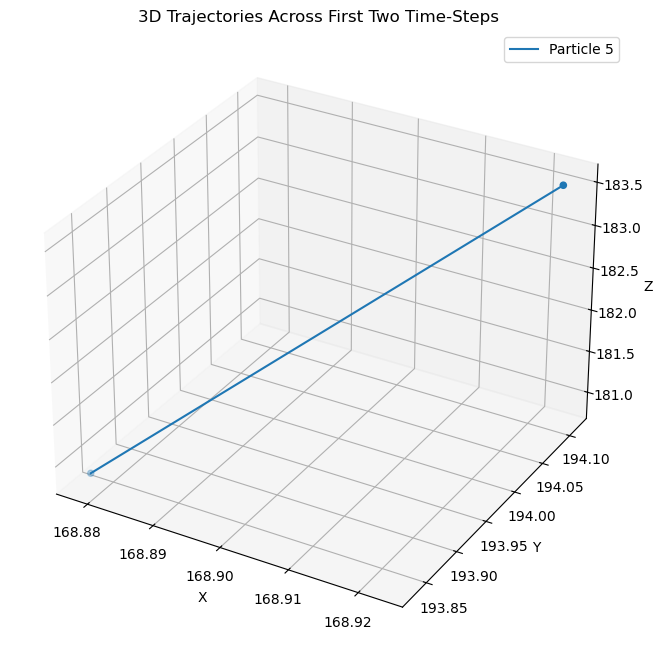

In [29]:
# Plot the trajectories in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each trajectory
for particle_id in trajectories['particle'].unique():
    traj = trajectories[trajectories['particle'] == particle_id]
    ax.scatter(traj['x'], traj['y'], traj['z'], marker='o')
    ax.plot(traj['x'], traj['y'], traj['z'], label=f'Particle {particle_id}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectories Across First Two Time-Steps')
ax.legend()

plt.show()